## Name - Kshitij Ajaykumar Patel

## USC ID - 1663106670

## GitHub ID - kapatel20

## Importing Necessary Modules

In [1]:
import os
import tensorflow as tf
import sklearn.model_selection
import sklearn
import shutil
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
import cv2
from tensorflow.keras.preprocessing import image

## Data Exploration and Data Preparation

In [2]:
def createData():
    classes = os.listdir("../data/Sport Images/")
    classes.remove("Image URLs")
    print(classes)
    ### Create a folder named final data
    os.mkdir("../data/final_data/")
    os.mkdir("../data/final_data/train/")
    os.mkdir("../data/final_data/validation/")
    os.mkdir("../data/final_data/test/")
    for cls in classes:
        os.mkdir("../data/final_data/train/"+cls+"/")
        os.mkdir("../data/final_data/validation/"+cls+"/")
        os.mkdir("../data/final_data/test/"+cls+"/")
    for cls in classes:
        
        path = "../data/Sport Images/"+cls+"/"
        img_list = os.listdir(path)
        train_list, test_list = sklearn.model_selection.train_test_split(img_list,test_size=0.3, random_state=0)
        val_list, test_list = sklearn.model_selection.train_test_split(test_list, test_size=0.5, random_state=0)

        for file in train_list:               
            shutil.copy("../data/Sport Images/"+cls+"/"+file, "../data/final_data/train/"+cls+"/"+file)
        for file in val_list:               
            shutil.copy("../data/Sport Images/"+cls+"/"+file, "../data/final_data/validation/"+cls+"/"+file)
        for file in test_list:               
            shutil.copy("../data/Sport Images/"+cls+"/"+file, "../data/final_data/test/"+cls+"/"+file)        

## Run the following line to prepare data

In [3]:
createData()

## Image Augmentation

In [3]:
img_augmentation = Sequential(
    [
        preprocessing.RandomCrop(220,220),
        preprocessing.RandomZoom(0.05,0.05),
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)      
    ],
    name="img_augmentation",
)

## Creating Loader for training, validation and testing

In [4]:
train_path = "../data/final_data/train/"
valid_path = "../data/final_data/validation/"
test_path = "../data/final_data/test/"

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=1, shuffle=False)

Found 2282 images belonging to 5 classes.
Found 488 images belonging to 5 classes.
Found 492 images belonging to 5 classes.


## Function to train model 

In [6]:
def trainModel(model_name, lr=0.001,epochs=100):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    if model_name=="efficientnet":
        model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    elif model_name=="rasnet":
        model = ResNet50(include_top=False, input_tensor=x, weights="imagenet")
    else:
        model = VGG16(include_top=False, input_tensor=x, weights="imagenet")
    
    model.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(5, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name=model_name)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    filepath = model_name+"_best_model.h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
#     custom_early_stop = CustomEarlyStopping(start_epoch=25, monitor='val_loss', patience=10)
    hist = model.fit(train_batches, epochs=epochs, validation_data=valid_batches, callbacks=[checkpoint,early_stopping])
    return model, hist

#### Training EfficientNet and saving the best model on training data

In [7]:
effnet_model, effnet_hist = trainModel("efficientnet")

Epoch 1/100
457/457 [==============================] - 17s 37ms/step - loss: 1.0243 - accuracy: 0.6350 - val_loss: 0.2856 - val_accuracy: 0.9180
Epoch 2/100
457/457 [==============================] - 14s 31ms/step - loss: 0.7396 - accuracy: 0.7480 - val_loss: 0.2915 - val_accuracy: 0.9098
Epoch 3/100
457/457 [==============================] - 14s 31ms/step - loss: 0.7554 - accuracy: 0.7454 - val_loss: 0.2356 - val_accuracy: 0.9283
Epoch 4/100
457/457 [==============================] - 14s 32ms/step - loss: 0.7587 - accuracy: 0.7450 - val_loss: 0.2149 - val_accuracy: 0.9365
Epoch 5/100
457/457 [==============================] - 14s 31ms/step - loss: 0.6451 - accuracy: 0.7713 - val_loss: 0.2120 - val_accuracy: 0.9303
Epoch 6/100
457/457 [==============================] - 14s 31ms/step - loss: 0.6867 - accuracy: 0.7748 - val_loss: 0.2383 - val_accuracy: 0.9139
Epoch 7/100
457/457 [==============================] - 14s 31ms/step - loss: 0.7175 - accuracy: 0.7682 - val_loss: 0.2661 - val_ac

#### #### Training ResNet and saving the best model on training data

In [8]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=5)
# test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.rasnet.preprocess_input).flow_from_directory(
#     directory=test_path, target_size=(224,224), batch_size=1, shuffle=False)

Found 2282 images belonging to 5 classes.
Found 488 images belonging to 5 classes.


In [9]:
rasnet_model, rasnet_hist = trainModel("rasnet")

Epoch 1/100
457/457 [==============================] - 26s 56ms/step - loss: 1.0274 - accuracy: 0.6604 - val_loss: 0.4438 - val_accuracy: 0.8627
Epoch 2/100
457/457 [==============================] - 24s 52ms/step - loss: 0.7585 - accuracy: 0.7524 - val_loss: 0.3956 - val_accuracy: 0.8832
Epoch 3/100
457/457 [==============================] - 24s 51ms/step - loss: 0.7453 - accuracy: 0.7695 - val_loss: 0.3299 - val_accuracy: 0.8811
Epoch 4/100
457/457 [==============================] - 24s 52ms/step - loss: 0.7233 - accuracy: 0.7862 - val_loss: 0.2861 - val_accuracy: 0.9057
Epoch 5/100
457/457 [==============================] - 24s 52ms/step - loss: 0.7275 - accuracy: 0.7822 - val_loss: 0.3546 - val_accuracy: 0.9057
Epoch 6/100
457/457 [==============================] - 24s 52ms/step - loss: 0.7103 - accuracy: 0.7844 - val_loss: 0.2952 - val_accuracy: 0.8996
Epoch 7/100
457/457 [==============================] - 23s 51ms/step - loss: 0.6815 - accuracy: 0.7888 - val_loss: 0.3036 - val_ac

#### Training VGG16 and saving the best model on training data

In [10]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=5)

Found 2282 images belonging to 5 classes.
Found 488 images belonging to 5 classes.


In [11]:
vgg_model, vgg_hist = trainModel("vgg")

Epoch 1/100
457/457 [==============================] - 35s 76ms/step - loss: 1.3568 - accuracy: 0.4956 - val_loss: 0.6357 - val_accuracy: 0.7828
Epoch 2/100
457/457 [==============================] - 33s 73ms/step - loss: 0.9294 - accuracy: 0.6630 - val_loss: 0.4867 - val_accuracy: 0.8402
Epoch 3/100
457/457 [==============================] - 33s 73ms/step - loss: 0.8200 - accuracy: 0.6985 - val_loss: 0.3977 - val_accuracy: 0.8627
Epoch 4/100
457/457 [==============================] - 33s 73ms/step - loss: 0.7873 - accuracy: 0.7195 - val_loss: 0.3572 - val_accuracy: 0.8791
Epoch 5/100
457/457 [==============================] - 33s 73ms/step - loss: 0.7599 - accuracy: 0.7191 - val_loss: 0.3271 - val_accuracy: 0.8832
Epoch 6/100
457/457 [==============================] - 33s 73ms/step - loss: 0.7543 - accuracy: 0.7366 - val_loss: 0.3515 - val_accuracy: 0.8934
Epoch 7/100
457/457 [==============================] - 33s 73ms/step - loss: 0.7460 - accuracy: 0.7287 - val_loss: 0.3572 - val_ac

### Loading the best models(w.r.t. validation accuracy)

In [12]:
best_effnet_model = tf.keras.models.load_model("efficientnet_best_model.h5")
best_rasnet_model = tf.keras.models.load_model("rasnet_best_model.h5")
best_vgg_model = tf.keras.models.load_model("vgg_best_model.h5")

#### Function to plot training and validation loss

In [13]:
def plotLossVsEpoch(model_name, history):
    
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(model_name)
    plt.show()

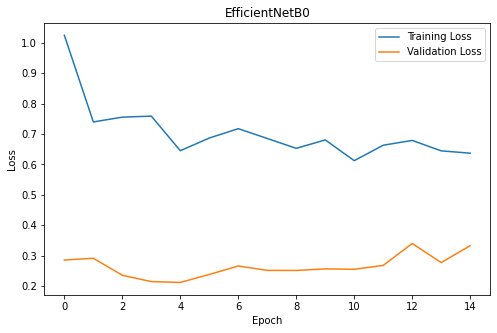

In [14]:
plotLossVsEpoch("EfficientNetB0",effnet_hist)

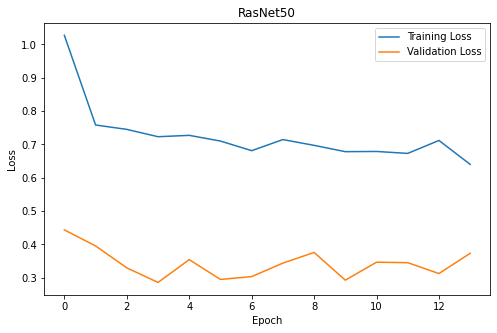

In [15]:
plotLossVsEpoch("RasNet50",rasnet_hist)

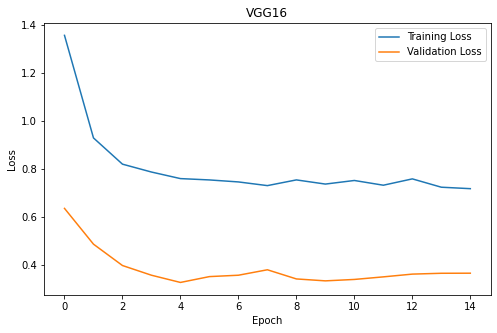

In [16]:
plotLossVsEpoch("VGG16",vgg_hist)

In [17]:
class_list = list(train_batches.class_indices.values())
class_list

[0, 1, 2, 3, 4]

#### Function to evaluate on test data

In [18]:
def evaluateModel(model, model_name, batch):
    if batch=="train":
        batch_path = train_path
    else:
        batch_path = test_path
    if model_name =="efficientnet":
        batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=batch_path, target_size=(224,224), batch_size=1, shuffle=False)
    elif model_name=="resnet":
        batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=batch_path, target_size=(224,224), batch_size=1, shuffle=False)
    else:
        batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=batch_path, target_size=(224,224), batch_size=1, shuffle=False)
    predictions = model.predict(batches)
    predicted_classes = np.argmax(predictions,axis=1)
    
    print("\nClasses : ", train_batches.class_indices)
    
    print("\nFor "+model_name+": " )
    print("\nConfusion Matrix : ")
    cm = sklearn.metrics.confusion_matrix(batches.classes, predicted_classes, labels=class_list)
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)
    disp.plot()
    plt.show()
    print("\nPrecision Value : ", sklearn.metrics.precision_score(batches.classes, predicted_classes,average="macro"))
    
    print("\nRecall Value : ", sklearn.metrics.recall_score(batches.classes, predicted_classes,average="macro"))
    
    print("\nAccuracy Value : ", sklearn.metrics.accuracy_score(batches.classes, predicted_classes))
    
    print("\nPrecision Value : ", sklearn.metrics.f1_score(batches.classes, predicted_classes,average="macro"))

Found 2282 images belonging to 5 classes.

Classes :  {'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

For efficientnet: 

Confusion Matrix : 


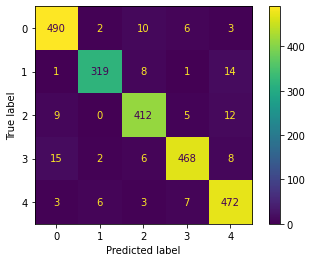


Precision Value :  0.9484682933063675

Recall Value :  0.9457503494678365

Accuracy Value :  0.9469763365468887

Precision Value :  0.9469284959625341


In [19]:
evaluateModel(best_effnet_model,"efficientnet", "train")

Found 492 images belonging to 5 classes.

Classes :  {'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

For efficientnet: 

Confusion Matrix : 


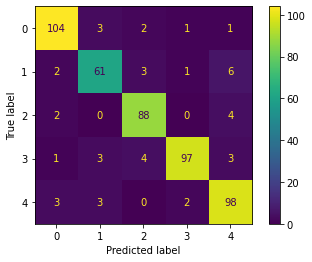


Precision Value :  0.9085225068898642

Recall Value :  0.9062800076187999

Accuracy Value :  0.9105691056910569

Precision Value :  0.9069320963242639


In [20]:
evaluateModel(best_effnet_model,"efficientnet", "test")

Found 2282 images belonging to 5 classes.

Classes :  {'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

For resnet: 

Confusion Matrix : 


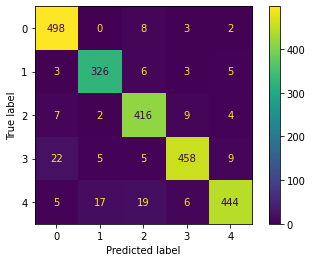


Precision Value :  0.9383248936004982

Recall Value :  0.9393762702512987

Accuracy Value :  0.9386503067484663

Precision Value :  0.9384438937057927


In [21]:
evaluateModel(best_rasnet_model,"resnet", "train")

Found 492 images belonging to 5 classes.

Classes :  {'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

For resnet: 

Confusion Matrix : 


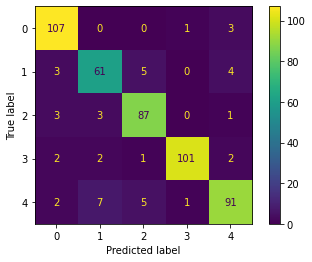


Precision Value :  0.9038948156417282

Recall Value :  0.9037576136873332

Accuracy Value :  0.9085365853658537

Precision Value :  0.9034071908576626


In [22]:
evaluateModel(best_rasnet_model,"resnet", "test")

Found 2282 images belonging to 5 classes.

Classes :  {'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

For VGG: 

Confusion Matrix : 


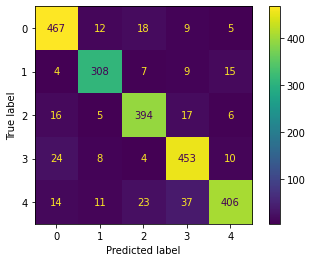


Precision Value :  0.8899379795076457

Recall Value :  0.8892192858343245

Accuracy Value :  0.8886941279579317

Precision Value :  0.8889351354794373


In [23]:
evaluateModel(best_vgg_model,"VGG", "train")

Found 492 images belonging to 5 classes.

Classes :  {'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

For VGG: 

Confusion Matrix : 


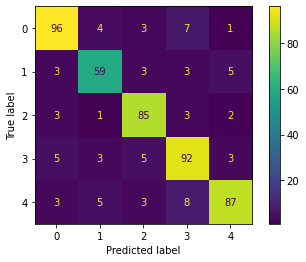


Precision Value :  0.8505343939667581

Recall Value :  0.8499891861857953

Accuracy Value :  0.8516260162601627

Precision Value :  0.849784152305251


In [24]:
evaluateModel(best_vgg_model,"VGG", "test")

# f) Video Classification using Moving Average

### Training the model on entire data

In [25]:
data_path = "../data/Sport Images/"

In [26]:
def trainModelVideo(model_name, train_batch, lr=0.001,epochs=100):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    if model_name=="efficientnet":
        model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    elif model_name=="resnet":
        model = ResNet50(include_top=False, input_tensor=x, weights="imagenet")
    else:
        model = VGG16(include_top=False, input_tensor=x, weights="imagenet")
    
    model.trainable = False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(5, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name=model_name)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    filepath = model_name+"_video_best_model.h5"
#     checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
    hist = model.fit(train_batch, epochs=epochs)
    
    return model, hist

In [27]:
train_data = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
    directory=data_path, target_size=(224,224), batch_size=5)

Found 3262 images belonging to 5 classes.


In [28]:
effnet_video, effnet_video_hist = trainModelVideo("efficientnet",train_batch=train_data,epochs=30)

Epoch 1/30
653/653 [==============================] - 19s 29ms/step - loss: 0.9708 - accuracy: 0.6625
Epoch 2/30
653/653 [==============================] - 17s 26ms/step - loss: 0.7525 - accuracy: 0.7477
Epoch 3/30
653/653 [==============================] - 17s 26ms/step - loss: 0.7281 - accuracy: 0.7633
Epoch 4/30
653/653 [==============================] - 17s 26ms/step - loss: 0.7131 - accuracy: 0.7670
Epoch 5/30
653/653 [==============================] - 17s 26ms/step - loss: 0.6764 - accuracy: 0.7713
Epoch 6/30
653/653 [==============================] - 17s 26ms/step - loss: 0.6643 - accuracy: 0.7771
Epoch 7/30
653/653 [==============================] - 17s 26ms/step - loss: 0.6993 - accuracy: 0.7679
Epoch 8/30
653/653 [==============================] - 17s 26ms/step - loss: 0.6812 - accuracy: 0.7759
Epoch 9/30
653/653 [==============================] - 17s 26ms/step - loss: 0.6486 - accuracy: 0.7781
Epoch 10/30
653/653 [==============================] - 17s 26ms/step - loss: 0.670

In [29]:
effnet_video.save("effnet_video.h5")

In [30]:
best_effnet_video_model = tf.keras.models.load_model("effnet_video.h5")

In [31]:
train_data = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
    directory=data_path, target_size=(224,224), batch_size=5)

Found 3262 images belonging to 5 classes.


In [32]:
resnet_video, resnet_video_hist = trainModelVideo("resnet",train_batch=train_data,epochs=30)

Epoch 1/30
653/653 [==============================] - 28s 44ms/step - loss: 0.9595 - accuracy: 0.6836
Epoch 2/30
653/653 [==============================] - 29s 44ms/step - loss: 0.7729 - accuracy: 0.7609
Epoch 3/30
653/653 [==============================] - 29s 44ms/step - loss: 0.7717 - accuracy: 0.7710
Epoch 4/30
653/653 [==============================] - 29s 44ms/step - loss: 0.7000 - accuracy: 0.7937
Epoch 5/30
653/653 [==============================] - 29s 44ms/step - loss: 0.7063 - accuracy: 0.7882
Epoch 6/30
653/653 [==============================] - 29s 44ms/step - loss: 0.7103 - accuracy: 0.7915
Epoch 7/30
653/653 [==============================] - 29s 44ms/step - loss: 0.7221 - accuracy: 0.7771
Epoch 8/30
653/653 [==============================] - 29s 44ms/step - loss: 0.7173 - accuracy: 0.7860
Epoch 9/30
653/653 [==============================] - 29s 45ms/step - loss: 0.6767 - accuracy: 0.7980
Epoch 10/30
653/653 [==============================] - 29s 44ms/step - loss: 0.721

In [33]:
resnet_video.save("resnet_video.h5")

In [34]:
best_resnet_video_model = tf.keras.models.load_model("resnet_video.h5")

In [35]:
train_data = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=data_path, target_size=(224,224), batch_size=5)

Found 3262 images belonging to 5 classes.


In [36]:
vgg_video, vgg_video_hist = trainModelVideo("vgg",train_batch=train_data,epochs=50)

Epoch 1/50
653/653 [==============================] - 39s 60ms/step - loss: 1.2080 - accuracy: 0.5598
Epoch 2/50
653/653 [==============================] - 40s 61ms/step - loss: 0.8556 - accuracy: 0.6867
Epoch 3/50
653/653 [==============================] - 40s 61ms/step - loss: 0.7990 - accuracy: 0.7158
Epoch 4/50
653/653 [==============================] - 40s 61ms/step - loss: 0.7677 - accuracy: 0.7207
Epoch 5/50
653/653 [==============================] - 40s 61ms/step - loss: 0.7560 - accuracy: 0.7256
Epoch 6/50
653/653 [==============================] - 40s 61ms/step - loss: 0.7286 - accuracy: 0.7382
Epoch 7/50
653/653 [==============================] - 40s 61ms/step - loss: 0.7286 - accuracy: 0.7296
Epoch 8/50
653/653 [==============================] - 40s 61ms/step - loss: 0.7731 - accuracy: 0.7265
Epoch 9/50
653/653 [==============================] - 40s 61ms/step - loss: 0.7538 - accuracy: 0.7253
Epoch 10/50
653/653 [==============================] - 40s 61ms/step - loss: 0.726

In [37]:
vgg_video.save("vgg_video.h5")

In [38]:
best_vgg_video_model = tf.keras.models.load_model("vgg_video.h5")

In [39]:
video_file_path = "../data/Sport Videos/"
video_classes = os.listdir(video_file_path)
print(video_classes)

['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']


### Function to Preprocess frames of video

In [40]:
def preprocessImage(img, model_name):
    img = cv2.resize(img, (224,224))
    if model_name=="efficientnet":
        return tf.keras.applications.efficientnet.preprocess_input(img)
    elif model_name=="resnet":
        return tf.keras.applications.resnet50.preprocess_input(img)
    return tf.keras.applications.vgg16.preprocess_input(img)

### Function to perform the task of classification on videos using moving average

In [41]:
def classifyVideo(model, model_name, train_batch):
    actual_class = []
    predicted_class = []
    
    average_probability = []
    for i in range(len(video_classes)):
        print("Class : ", video_classes[i] )
        video_path = video_file_path+video_classes[i]+"/"
        video_list = os.listdir(video_path)
        
        for video in video_list:
            path = video_path+video
            video = cv2.VideoCapture(path)
            actual_class.append(i)
            total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_interval = max(1, total_frames // 100)
            frames = []

            for j in range(0, total_frames, frame_interval):
                video.set(cv2.CAP_PROP_POS_FRAMES, j)
                ret, frame = video.read()

                if ret:
                    preprocessed_frame = preprocessImage(frame, model_name)
                    frames.append(preprocessed_frame)

            frames = np.array(frames)
            predictions = model.predict(frames)
            predictions = np.mean(predictions, axis=0)
            average_probability.append(predictions)
            predicted_class.append(np.argmax(predictions))
            
    return actual_class, predicted_class, average_probability            

#### Function to evaluate on video data

In [42]:
def evaluateModelVideo(actual, predicted, model_name):
    print("\nClasses : ", train_data.class_indices)
    
    print("\nFor "+model_name+": " )
    print("\nConfusion Matrix : ")
    cm = sklearn.metrics.confusion_matrix(actual, predicted, labels=class_list)
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)
    disp.plot()
    plt.show()
    print("\nPrecision Value : ", sklearn.metrics.precision_score(actual, predicted,average="macro"))
    
    print("\nRecall Value : ", sklearn.metrics.recall_score(actual, predicted,average="macro"))
    
    print("\nAccuracy Value : ", sklearn.metrics.accuracy_score(actual, predicted))
    
    print("\nPrecision Value : ", sklearn.metrics.f1_score(actual, predicted,average="macro"))

In [43]:
actual_class_effnet, predicted_class_effnet, predicted_class_prob_effnet = classifyVideo(best_effnet_video_model,"efficientnet", train_data)

Class :  baseball
Class :  basketball
Class :  fencing
Class :  tennis
Class :  volleyball



Classes :  {'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

For EfficientNetB0: 

Confusion Matrix : 


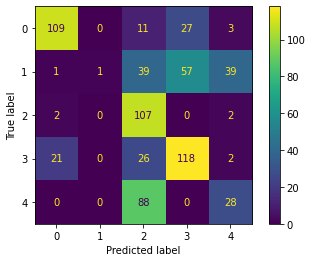


Precision Value :  0.6353839229479794

Recall Value :  0.5291792074791513

Accuracy Value :  0.5330396475770925

Precision Value :  0.4558646873355182


In [44]:
evaluateModelVideo(actual_class_effnet, predicted_class_effnet, "EfficientNetB0")

In [45]:
actual_class_resnet, predicted_class_resnet, predicted_class_prob_resnet = classifyVideo(best_resnet_video_model,"resnet", train_data)

Class :  baseball
Class :  basketball
Class :  fencing
Class :  tennis
Class :  volleyball



Classes :  {'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

For ResNet: 

Confusion Matrix : 


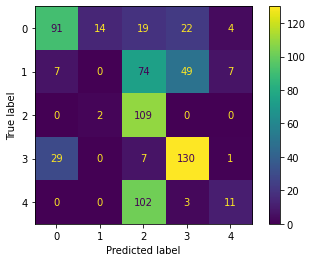


Precision Value :  0.43650670394188157

Recall Value :  0.49238386972560005

Accuracy Value :  0.5007342143906021

Precision Value :  0.40654187910966905


In [46]:
evaluateModelVideo(actual_class_resnet, predicted_class_resnet, "ResNet")

In [47]:
actual_class_vgg, predicted_class_vgg, predicted_class_prob_vgg = classifyVideo(best_vgg_video_model,"vgg", train_data)

Class :  baseball
Class :  basketball
Class :  fencing
Class :  tennis
Class :  volleyball



Classes :  {'baseball': 0, 'basketball': 1, 'fencing': 2, 'tennis': 3, 'volleyball': 4}

For VGG: 

Confusion Matrix : 


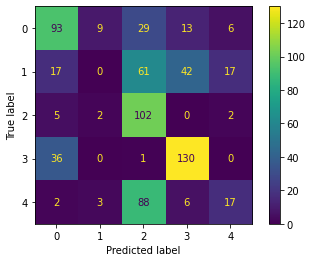


Precision Value :  0.4112445276223064

Recall Value :  0.492782751365861

Accuracy Value :  0.5022026431718062

Precision Value :  0.415143281212373


In [48]:
evaluateModelVideo(actual_class_vgg, predicted_class_vgg, "VGG")